# Titanic Survival Analytics - Report
***

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early hours of 15 April 1912, after colliding with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. This sensational tragedy shocked the international community and led to better safety regulations for ships.
<br><br>
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
<br><br>
This notebook is an analysis on what sorts of people were likely to survive. In partciular, I build a Machine Learning model to predict which passengers survived the tragedy.

<img src="../images/titanic.png"/>

## Table Of Contents
***
### Objective
- [Goal of the notebook](#datacleaning2)

### Data Quality Check
- [Simple Inspection of Data](#datacleaning)

### Data Preprocessing
- [Missing Values](#missingValues)
- [Imputation](#imputation)
- [Feature Engineering](#newFeatures)

### Descriptive Statistics
- [Univariate Analysis](#univariateAnalysis)
- [Bivariate Values](#bivariateAnalysis)
- [Multivariate Values](#multivariateAnalysis)
- [Pearson Correlation](#pearsonCorr)

### Modelling
- [Decision Tree](#decisionTree)
- [Adaboost Classifier](#adaboost)
- [Bagging Classifier](#bagging)
- [Extra Trees Classifier](#extraTrees)
- [Gradient Boosting Classifier](#gradientBoost)
- [Random Forest Classifier](#randomForest)
- [Gaussian Process Classifier](#gaussianProcess)
- [Logistic Regression](#logisticRegression)
- [Bernoulli NB](#bernoulliNB)
- [K Neighbours Classifier](#kNeighbours)
- [SVC](#svc)
- [XGB Classifier](#xgb)
- [Comparing the ML Models](#comparison)

### Voting Classifiers
- [Hard Voting Classifier](#hardVote)
- [Soft Voting Classifier](#softVote)
- [Save Models to File](#saveModels)

### Submission

### Conclusion

<a id='datacleaning2'></a>
# Objective
***

- To understand what sorts of people were likely to survive the tragedy.
- Build a Machine Learning model that can predict which passengers survived the tragedy.

# Import Packages
***

In [517]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew 
import re

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Read the data
***

In [518]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

<a id='datacleaning'></a>
# Data Quality Check
***

In [519]:
# Examine the train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [520]:
# Examine the test dataset
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [521]:
# Check the type of our features. Are there any data inconsistencies?
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [522]:
# Can you check to see if there are any missing values in our data set
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [523]:
# What is the size of the training set?
train.shape

(891, 12)

In [524]:
# What is the size of the test set?
test.shape

(418, 11)

In [525]:
# concatenating the data
all_data = pd.concat((train.drop(['PassengerId', 'Survived'], axis = 1),
                      test.drop(['PassengerId'], axis = 1))).reset_index(drop=True)

# Function to split back train and test set from "all_data"
def updateTrainTestData():
    global train
    global test
    global all_data
    ntrain = train.shape[0]
    ntest = test.shape[0]

    train_id = train['PassengerId']
    test_id = test['PassengerId']
    label = train['Survived']

    train = all_data[:ntrain]
    train['Survived'] = label
    train['PassengerId'] = train_id
    test = all_data[ntrain:].reset_index().drop(['index'], axis = 1)
    test['PassengerId'] = test_id
    

# Data Preprocessing
***

<img src="../images/preprocessing.gif"/>

<a id = '#missingValues'></a>
## Missing Values
***

In [526]:
missing_total = all_data.isnull().sum().sort_values(ascending=False)
missing_total

Cabin       1014
Age          263
Embarked       2
Fare           1
Ticket         0
Parch          0
SibSp          0
Sex            0
Name           0
Pclass         0
dtype: int64

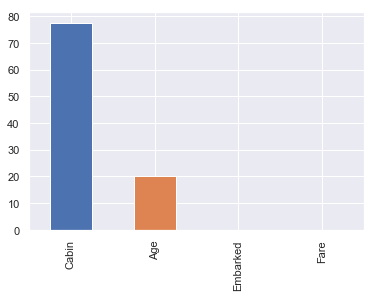

In [527]:
percent = (all_data.isnull().sum() * 100/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Percent'] > 0]['Percent'].plot.bar(by = 'Percent', figsize=(6,4))

<a id = '#imputation'></a>
## Imputation
***

The large number of missing values in "Cabin" supposedly imply that those passengers didn't have any cabin.

In [528]:
# imputing "Cabin" with "None"
all_data['Cabin'] = all_data['Cabin'].fillna("None")

We have plenty of missing values in "Age". Lets generate random numbers between (mean - std) and (mean + std) and fill them.

In [529]:
# imputing "Age" with random number between (mean - std) and (mean + std) 
age_avg = all_data['Age'].mean()
age_std = all_data['Age'].std()
age_null_count = all_data['Age'].isnull().sum()

age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
all_data['Age'].loc[all_data['Age'].isnull()] = age_null_random_list

In [530]:
# imputing "Embarked" with 'S'
all_data['Embarked'] = all_data['Embarked'].fillna('S')

In [531]:
# Displaying row with missing "Fare" value
all_data.loc[all_data['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,None,S


Let us find most frequent "Fare" for male passengers of Pclass "3", who embarked on "S" and use the value to replace the missing "Fare" value.

In [532]:
# Imputing 'Fare' with most frequent value of the passengers who has same Pclass, Sex, and Embarked
fare_val = all_data[(all_data['Sex'] == 'male') & 
                    (all_data['Pclass'] == 3) & (all_data['Embarked'] == 'S')]['Fare'].mode()

all_data['Fare'].fillna(fare_val[0], inplace = True)

<a id = 'newFeatures'></a>
## Feature Engineering
***

In [533]:
# Family Size
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

# Is alone
all_data.loc[all_data['FamilySize'] == 1, 'IsAlone'] = '1'
all_data.loc[all_data['FamilySize'] > 1, 'IsAlone'] = '0'

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Title
all_data['Title'] = all_data['Name'].apply(get_title)
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess',
                                             'Capt', 'Col','Don', 
                                             'Dr', 'Major', 'Rev', 
                                             'Sir', 'Jonkheer', 'Dona'], 'Rare')

all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

# Last name
all_data['LastName'] = all_data['Name'].str.partition(',')[0]

# Kids upto 5 years old are most likely to survive
all_data['IsBaby'] = all_data['Age'].apply(lambda x: 1 if x < 6 else 0)

# Let's find their mother. Cause kids won't be sent alone for rescue
babyLastName = list(np.unique(all_data[all_data['IsBaby'] == 1][['LastName']].values))

def isMother(x):
    if ((x['Age'] > 15) & (x['Sex'] == 'female') 
        & (x['LastName'] in babyLastName) & (x['Parch'] != 0)):
        return 1
    else:
        return 0

all_data['IsMother'] = all_data[['Age', 'Sex', 'LastName', 'Parch']].apply(isMother, axis=1)

# Let us make a new feature for unseparable duo - mother and baby
all_data['IsMotherBabyDuo'] = all_data['IsBaby'] | all_data['IsMother']

# Type Cast
all_data['IsMotherBabyDuo'] = all_data['IsMotherBabyDuo'].astype('object')
all_data['IsMother'] = all_data['IsMother'].astype('object')
all_data['IsBaby'] = all_data['IsBaby'].astype('object')

# Bucketize Age
all_data.loc[ all_data['Age'] <= 16, 'AgeBucket'] = '0'
all_data.loc[(all_data['Age'] > 16) & (all_data['Age'] <= 32), 'AgeBucket'] = '1'
all_data.loc[(all_data['Age'] > 32) & (all_data['Age'] <= 48), 'AgeBucket'] = '2'
all_data.loc[(all_data['Age'] > 48) & (all_data['Age'] <= 64), 'AgeBucket'] = '3'
all_data.loc[ all_data['Age'] > 64, 'AgeBucket'] = '4'
    
# Bucketize Fare
all_data.loc[ all_data['Fare'] <= 7.91, 'FareBucket'] = '0'
all_data.loc[(all_data['Fare'] > 7.91) & (all_data['Fare'] <= 14.454), 'FareBucket'] = '1'
all_data.loc[(all_data['Fare'] > 14.454) & (all_data['Fare'] <= 31), 'FareBucket'] = '2'
all_data.loc[ all_data['Fare'] > 31, 'FareBucket'] = '3'

# Has Cabin
all_data.loc[(all_data['Cabin'] == 'None', 'HasCabin')] = '0'
all_data['HasCabin'].fillna('1', inplace = True)

# Age*Class
all_data['Age*Class'] = (all_data.Age * all_data.Pclass).astype('float')

# Pclass
all_data['Pclass'] = all_data['Pclass'].astype('object')

In [534]:
# Function to do label encoding of categorical attributes
def encoding():
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    all_data['Title'] = all_data['Title'].map(title_mapping).astype(int)
    all_data['Title'] = all_data['Title'].fillna(0)
    
    # Mapping Embarked
    all_data['Embarked'] = all_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Sex
    all_data['Sex'] = all_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
# Function to typecast features in appropriate data types
def typeCast():
    all_data['Pclass'] = all_data['Pclass'].astype('int')
    all_data['AgeBucket'] = all_data['AgeBucket'].astype(int)
    all_data['FareBucket'] = all_data['FareBucket'].astype(int)
    all_data['IsAlone'] = all_data['IsAlone'].astype(int)
    all_data['HasCabin'] = all_data['HasCabin'].astype(int)
    all_data['IsMotherBabyDuo'] = all_data['IsMotherBabyDuo'].astype('int')

***

In [535]:
# Update train and test sets    
updateTrainTestData()

# Exploratory Data Analysis
***

<img src='../images/explore.gif'>

In [536]:
# Feature Selection
features = ['Pclass', 'Sex', 'SibSp', 'Parch','Embarked', 'FamilySize', 'IsAlone', 'Title',
       'IsMotherBabyDuo', 'AgeBucket', 'FareBucket','HasCabin', 'Age*Class', 'Survived']

# numeric data
quantitative = ['Age', 'Fare', 'FamilySize', 'Age*Class']

# categorical data
qualitative = ['Pclass', 'Sex', 'SibSp', 'Parch', 'HasCabin', 'Embarked', 
               'IsAlone', 'Title', 'IsBaby', 'IsMother', 'IsMotherBabyDuo', 'AgeBucket', 'FareBucket']

***

In [537]:
# Display the statistical overview of the numerical attributes of the dataset
all_data.describe()

,Age,SibSp,Parch,Fare,FamilySize,Age*Class
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.00000
mean,29.679656,0.498854,0.385027,33.276193,1.883881,64.06793
std,13.351944,1.041658,0.865560,51.743584,1.583639,32.79117
min,0.170000,0.000000,0.000000,0.000000,1.000000,0.51000
25%,21.000000,0.000000,0.000000,7.895800,1.000000,42.00000
50%,28.000000,0.000000,0.000000,14.454200,1.000000,60.00000
75%,37.000000,1.000000,0.000000,31.275000,2.000000,84.00000
max,80.000000,8.000000,9.000000,512.329200,11.000000,222.00000


<b>Observation</b>
- Feature "Pclass" is a nominal data.
- The minimum value of "SibSp" and "Parch" are 0. That implies there are few passengers who are travelling alone. That's how we created "IsAlone" feature in previous section.
- I realised that there are only 4 people on board who paid a "Fare" of 512. Must be VVIP. 
- The second highest "Fare" price is 263 (which is held by 7 passengers), while the third highest "Fare" price is 262.3750 (which is again held by 7 passengers). Need to analyse if there is any significance of the 0.625 difference in their prices.
- The max value of "Parch" is set to 9 which is held by two passengers exactly. Similarly, the second highest value of "Parch" is set to 6, which is again held by two passengers. Suposedly, they are two couples.
- Feature "Age" has 12 values which lie between 0 to 1 (e.g., 0.17, 0.33, 0.42, etc). On reading "Data description", I figured out that the age of passengers below 1 year old has been specified in fractions.

In [538]:
# Display the statistical overview of the categorical attributes of the dataset
all_data.describe(include = ['object'])

,Pclass,Name,Sex,Ticket,Cabin,Embarked,IsAlone,Title,LastName,IsBaby,IsMother,IsMotherBabyDuo,AgeBucket,FareBucket,HasCabin
count,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309
unique,3,1307,2,929,187,3,2,5,875,2,2,2,5,4,2
top,3,"Kelly, Mr. James",male,CA. 2343,None,S,1,Mr,Andersson,0,0,0,1,0,0
freq,709,2,843,11,1014,916,790,757,11,1253,1273,1217,685,337,1014


<b>Observations:</b>
 - Cause most of the values of feature "Cabin" are missing, I assumed, they must be the people who hadn't had cabin alotted. A new feature "HasCabin" has been created in previous section, based on this idea.
 - Field "Ticket" don't seem to provide any useful information.
 - The "Name" of passengers are presented in an interesting way, i.e., last_name, Mr./Miss/Mrs first_name+middle_name. I have made use of the Last Name of passenger and their age to find "Mother-Baby Duo". The new feature "IsMotherBabyDuo" reflects that.

In [539]:
# Display the statistical overview of target variable "Survived"
train['Survived'].astype(str).describe()

count     891
unique      2
top         0
freq      549
Name: Survived, dtype: object

<a id = 'univariateAnalysis'></a>
## Univariate Analysis
***

### Target variable: Survived
***

In [540]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

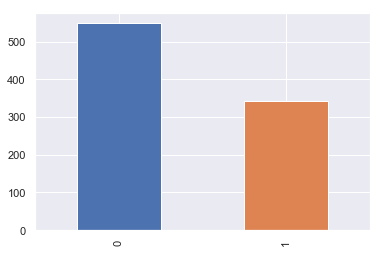

In [541]:
train['Survived'].value_counts().plot.bar()

- Only 38.38% of passengers survived the accident

### Numerical Attributes
***

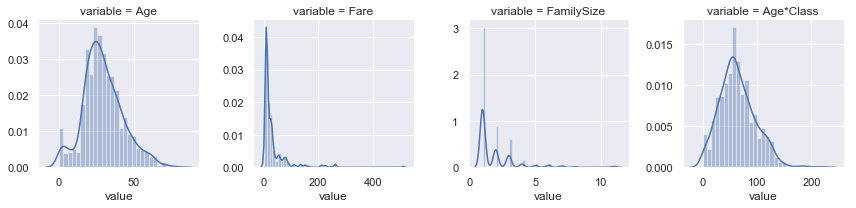

In [542]:
f = pd.melt(all_data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Text(0,0.5,'Age * Class')

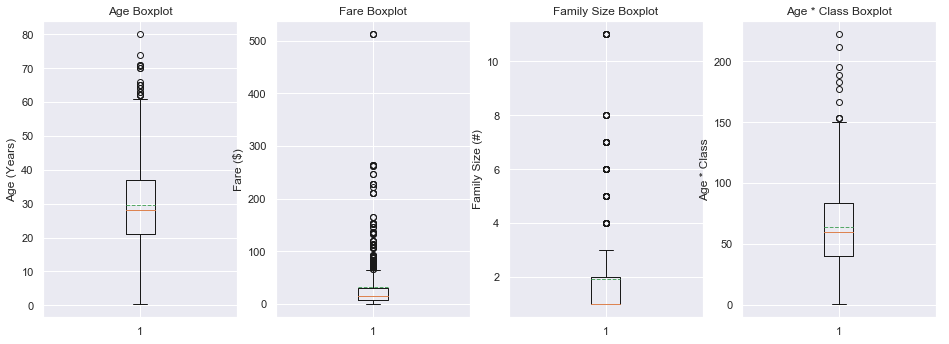

In [543]:
plt.figure(figsize=[16,12])

plt.subplot(241)
plt.boxplot(x=train['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(242)
plt.boxplot(train['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(243)
plt.boxplot(train['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(244)
plt.boxplot(train['Age*Class'], showmeans = True, meanline = True)
plt.title('Age * Class Boxplot')
plt.ylabel('Age * Class')

<b>Observations:</b>
- There are many passengers for whom "SibSp" is 0, which means they do not have siblings/spouse aboard.
- There are many passengers for whom "Parch" is 0, which means they do not have parents/childrens aboard.
- There are very few passengers on higher end of "Fare".

### Categorical Attributes
***

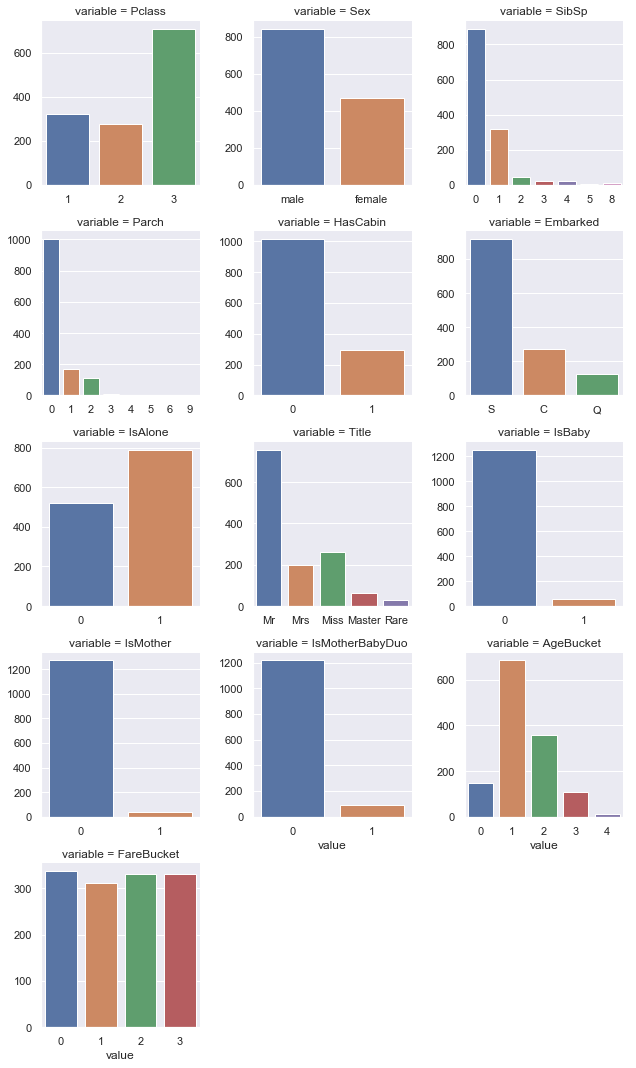

In [544]:
def countplot(x,**kwargs):
    sns.set(style="darkgrid")
    ax = sns.countplot(x=x, data=f)
    

f = pd.melt(all_data, value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(countplot, "value")

<a id = 'bivariateAnalysis'></a>
## Bivariate Analysis
***

### Numerical Attributes
***

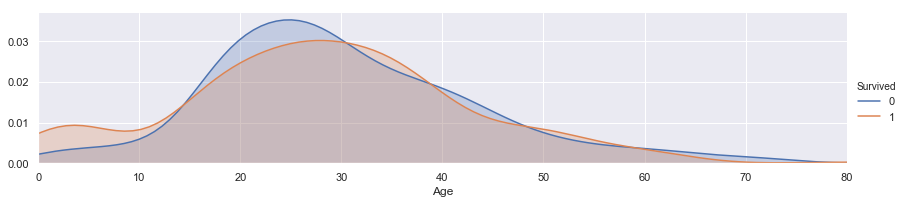

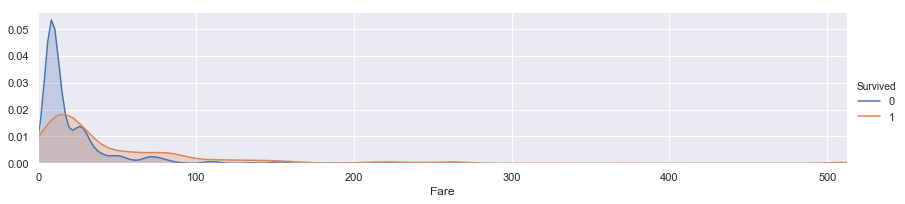

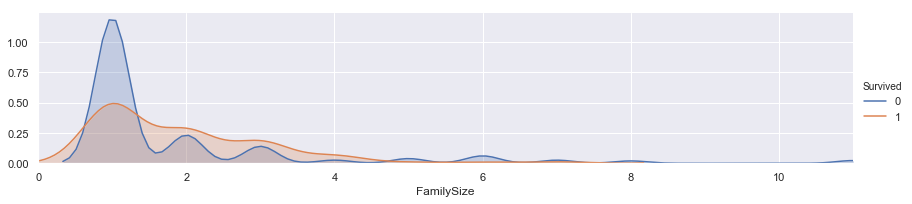

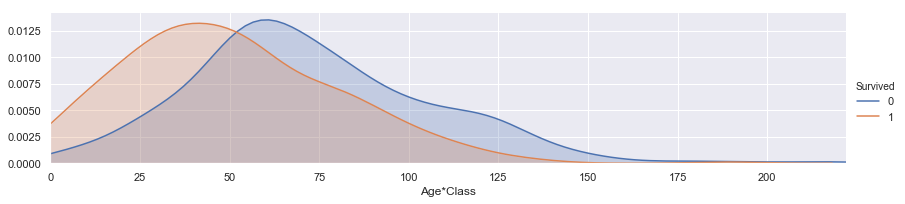

In [545]:
for col in quantitative:   
    a = sns.FacetGrid( train, hue = 'Survived', aspect=4 )
    a.map(sns.kdeplot, col, shade= True )
    a.set(xlim=(0 , train[col].max()))
    a.add_legend()

### Categorical Attributes
***

In [546]:
#Discrete Variable Correlation by Survival using group by
for x in qualitative:
    print('Survival Correlation by:', x)
    print(train[[x, 'Survived']].groupby(x, as_index=False).mean())
    print('-'*10, '\n')

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: HasCabin
  HasCabin  Survived
0        0  0.299854
1        1  0.666667
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: IsAlone
  IsAlone  Survived
0       0  0.505650
1       1  0.303538
---------- 

Survival Correlation by: Title
   

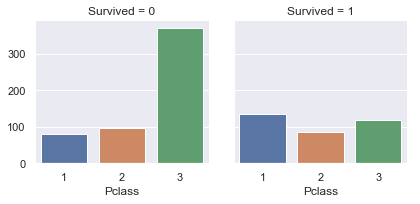

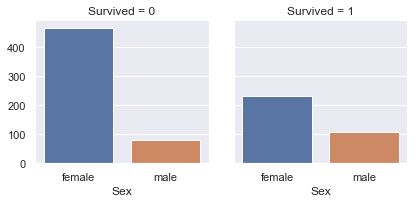

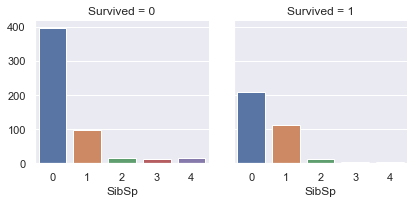

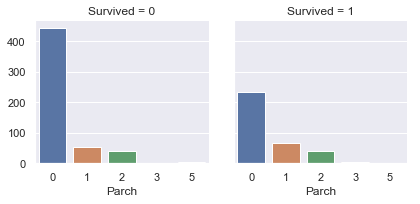

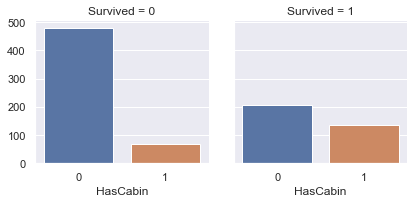

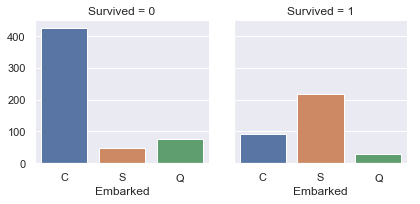

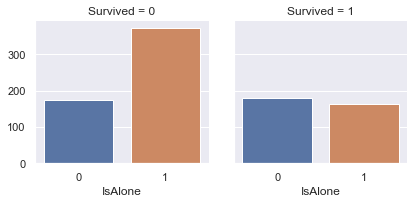

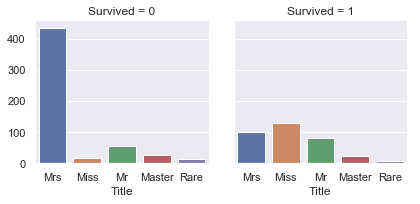

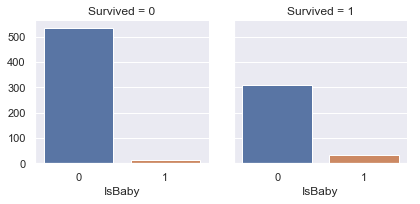

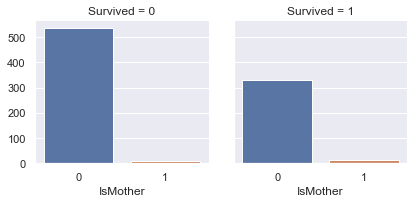

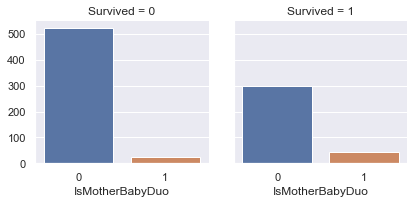

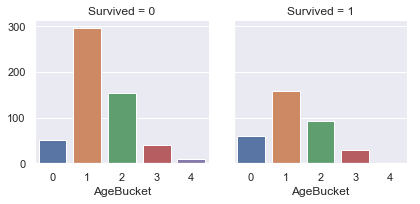

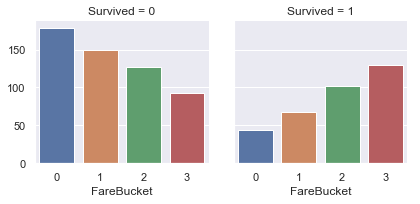

In [547]:
def countplot(x,**kwargs):
    sns.set(style="darkgrid")
    ax = sns.countplot(x=x, data=train)
    
for col in qualitative:
    g = sns.FacetGrid(train, col="Survived", col_wrap = 2)
    g.map(countplot, col)

<a id='multivariateAnalysis'></a>
## Multivariate Analysis
***

### Pclass
***
Pclass is an important criteria for survival. Let us plot other features along with "Pclass" to understand the survival pattern.

Text(0.5,1,'Pclass vs Age*Class - Survival')

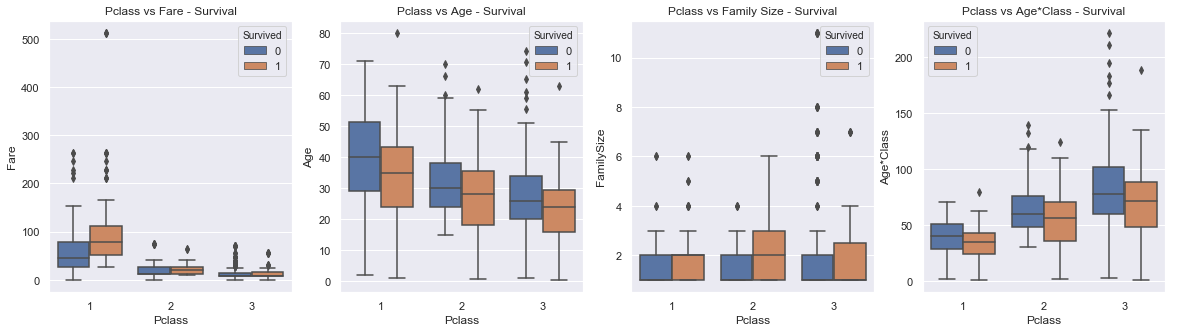

In [548]:
fig, (axis1,axis2,axis3,axis4) = plt.subplots(1,4,figsize=(20,5))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = train, ax = axis1)
axis1.set_title('Pclass vs Fare - Survival')

sns.boxplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = train, ax = axis2)
axis2.set_title('Pclass vs Age - Survival')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = train, ax = axis3)
axis3.set_title('Pclass vs Family Size - Survival')

sns.boxplot(x = 'Pclass', y ='Age*Class', hue = 'Survived', data = train, ax = axis4)
axis4.set_title('Pclass vs Age*Class - Survival')

Text(0.5,1,'Pclass vs HasCabin - Survival')

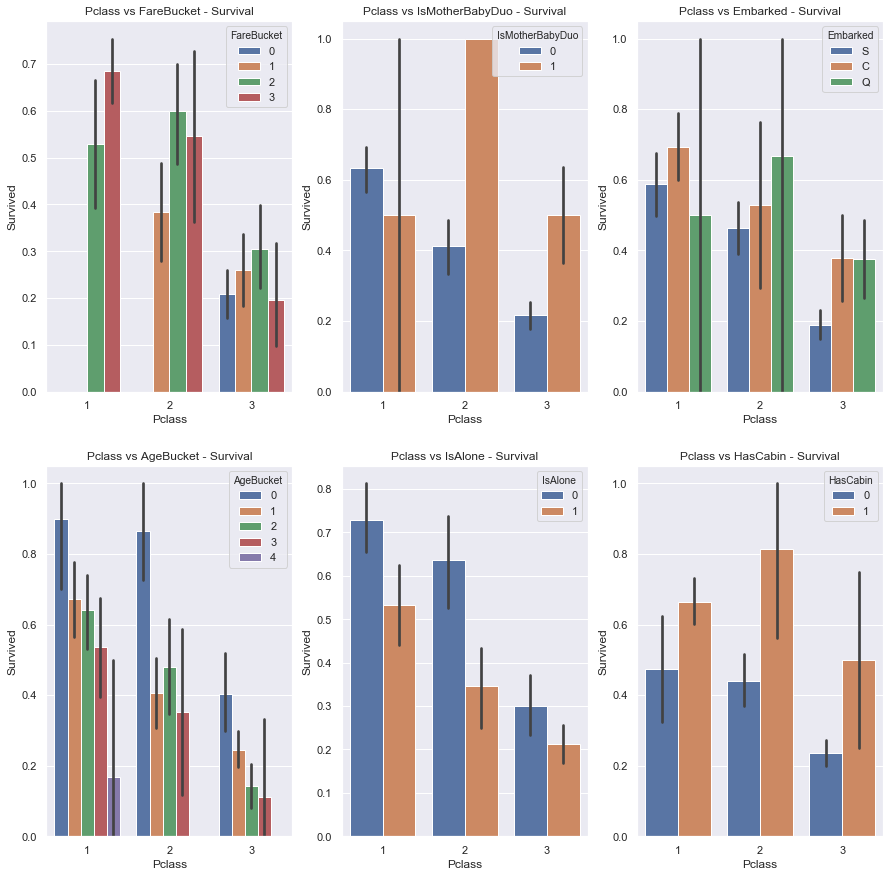

In [549]:
fig, saxis = plt.subplots(2,3,figsize=(15,15))

sns.barplot(x = 'Pclass', y = 'Survived', hue = 'FareBucket', data = train, 
            ax = saxis[0,0]).set_title('Pclass vs FareBucket - Survival')

sns.barplot(x = 'Pclass', y = 'Survived', hue = 'IsMotherBabyDuo', data = train, 
            ax = saxis[0,1]).set_title('Pclass vs IsMotherBabyDuo - Survival')

sns.barplot(x = 'Pclass', y ='Survived', hue = 'Embarked', data = train, 
            ax = saxis[0,2]).set_title('Pclass vs Embarked - Survival')

sns.barplot(x = 'Pclass', y ='Survived', hue = 'AgeBucket', data = train, 
            ax = saxis[1,0]).set_title('Pclass vs AgeBucket - Survival')

sns.barplot(x = 'Pclass', y ='Survived', hue = 'IsAlone', data = train, 
            ax = saxis[1,1]).set_title('Pclass vs IsAlone - Survival')

sns.barplot(x = 'Pclass', y ='Survived', hue = 'HasCabin', data = train, 
            ax = saxis[1,2]).set_title('Pclass vs HasCabin - Survival')


### Sex
***
"Sex" is an important criteria for survival. Let us use categorical features along with "Sex" to see the survival pattern.

Text(0.5,1,'Sex vs Age*Class - Survival')

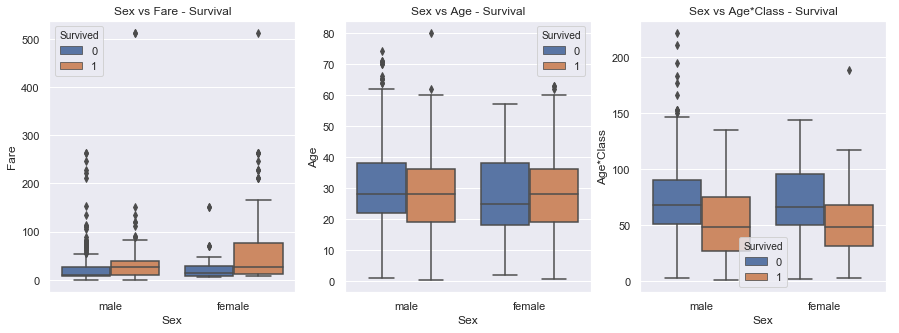

In [550]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.boxplot(x = 'Sex', y = 'Fare', hue = 'Survived', data = train, ax = axis1)
axis1.set_title('Sex vs Fare - Survival')

sns.boxplot(x = 'Sex', y = 'Age', hue = 'Survived', data = train, ax = axis2)
axis2.set_title('Sex vs Age - Survival')

sns.boxplot(x = 'Sex', y = 'Age*Class', hue = 'Survived', data = train, ax = axis3)
axis3.set_title('Sex vs Age*Class - Survival')

Text(0.5,1,'Sex vs Pclass - Survival')

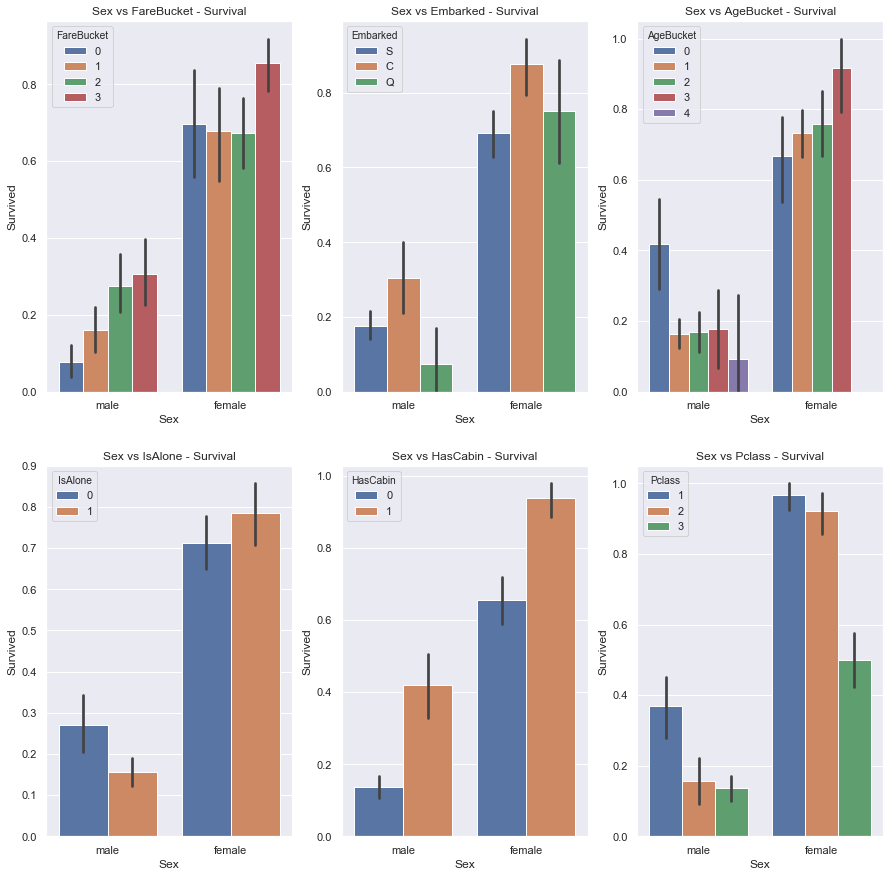

In [551]:
fig, saxis = plt.subplots(2,3,figsize=(15,15))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'FareBucket', data = train, 
            ax = saxis[0,0]).set_title('Sex vs FareBucket - Survival')

sns.barplot(x = 'Sex', y ='Survived', hue = 'Embarked', data = train, 
            ax = saxis[0,1]).set_title('Sex vs Embarked - Survival')

sns.barplot(x = 'Sex', y ='Survived', hue = 'AgeBucket', data = train, 
            ax = saxis[0,2]).set_title('Sex vs AgeBucket - Survival')

sns.barplot(x = 'Sex', y ='Survived', hue = 'IsAlone', data = train, 
            ax = saxis[1,0]).set_title('Sex vs IsAlone - Survival')

sns.barplot(x = 'Sex', y ='Survived', hue = 'HasCabin', data = train, 
            ax = saxis[1,1]).set_title('Sex vs HasCabin - Survival')

sns.barplot(x = 'Sex', y ='Survived', hue = 'Pclass', data = train, 
            ax = saxis[1,2]).set_title('Sex vs Pclass - Survival')

### Pclass - Sex 
***
Pclass and Sex are undoubtedly a major factor for survival. Lets see the survival pattern of other features, given Pclass and Sex.

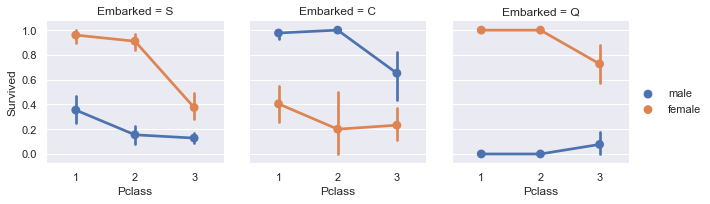

In [552]:
# Pclass - Sex - Embark Port versus Survived
e = sns.FacetGrid(train, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

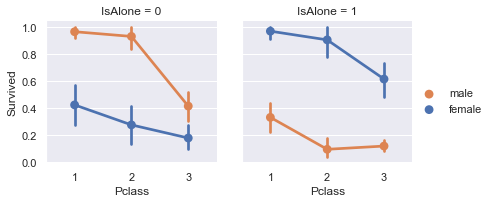

In [553]:
# Pclass - Sex - IsAlone versus Survived
e = sns.FacetGrid(train, col = 'IsAlone')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

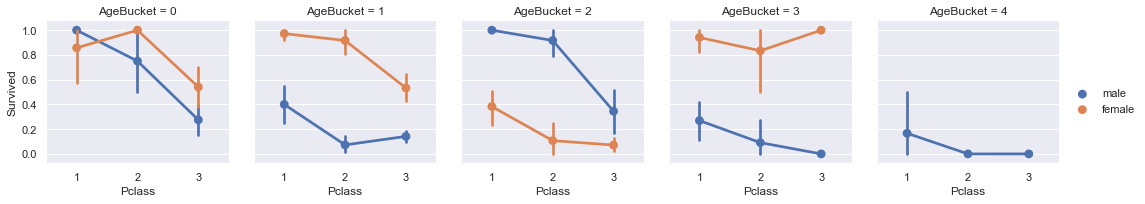

In [554]:
# Pclass - Sex - AgeBucket versus Survived
e = sns.FacetGrid(train, col = 'AgeBucket')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

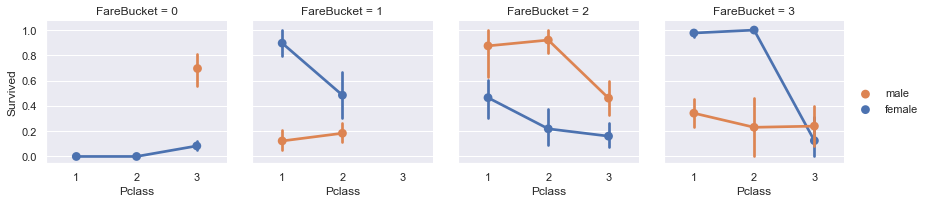

In [555]:
# Pclass - Sex - FareBucket versus Survived
e = sns.FacetGrid(train, col = 'FareBucket')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

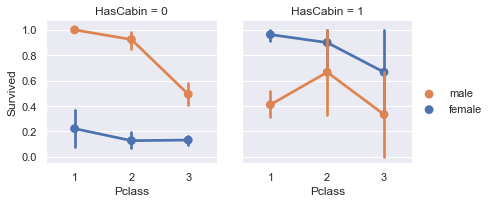

In [556]:
# Pclass - Sex - HasCabin versus Survived
e = sns.FacetGrid(train, col = 'HasCabin')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

In [557]:
# encoding
encoding()
# typecast
typeCast()
# update train and test data
updateTrainTestData()

<a id = 'pearsonCorr'></a>
### Pearson Correlation Heatmap
***

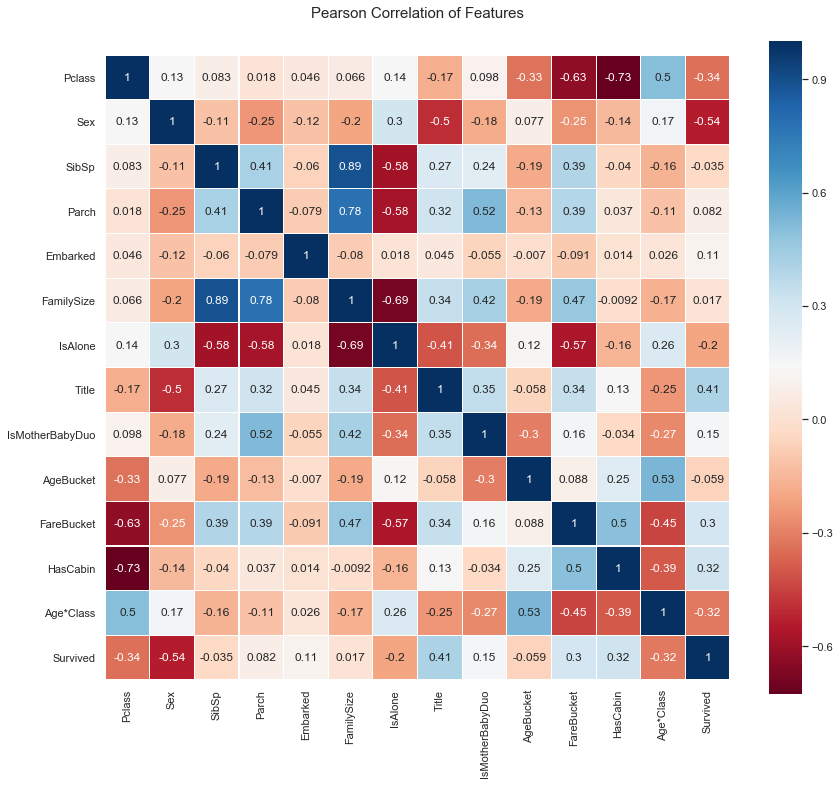

In [558]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train[features].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

***

In [559]:
X = train[features].drop(['Survived'], axis=1)
y = train['Survived']

***

# Modelling
***

In [616]:
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, cross_validate, train_test_split
from sklearn import feature_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

In [562]:
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 
               'MLA Test Accuracy Mean']
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [563]:
cv_split = 10
row_index = 0

In [617]:
# Function to perform grid search to find appropriate hyperparameters for the best fit of the model
# Metric Used: Accuracy
# Technique: cross-validation
def fit(alg, param_grid):
    global row_index
    global cv_split
    model_cv = model_selection.GridSearchCV(alg,
                                        param_grid=param_grid, scoring = 'accuracy', cv = cv_split)
    model_cv.fit(X, y)
    
    # insert accuracy scores in MLA_compare for comparison of models
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(model_cv.best_params_)
    MLA_compare.loc[row_index, 
                    'MLA Train Accuracy Mean'] = model_cv.cv_results_['mean_train_score'][model_cv.best_index_]*100
    MLA_compare.loc[row_index, 
                    'MLA Test Accuracy Mean'] = model_cv.cv_results_['mean_test_score'][model_cv.best_index_]*100
    
    print('Best Parameters: ', model_cv.best_params_)
    print("Training score mean: {:.2f}". format(model_cv.cv_results_['mean_train_score'][model_cv.best_index_]*100)) 
    print("Test score mean: {:.2f}". format(model_cv.cv_results_['mean_test_score'][model_cv.best_index_]*100))
    row_index = row_index + 1
    
    return model_cv

<a id = 'decisionTree'></a>
### Decision Tree
***

In [565]:
# Hyperparameters
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_min_samples_leaf = [1,5,10,.03,.05]
grid_criterion = ['gini', 'entropy']
grid_seed = [0]

In [566]:
param_grid = {'criterion': grid_criterion,
              #'splitter': ['best', 'random'], # default is best
              'max_depth': grid_max_depth,
              #'min_samples_split': grid_min_samples, # default is 2
              #'min_samples_leaf': grid_min_samples_leaf, # default is 1
              #'max_features': [None, 'auto'],
              'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
dtreeCV = fit(tree.DecisionTreeClassifier(), param_grid)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'random_state': 0}
Training score mean: 84.14
Test score mean: 82.04


/Users/bishwaraj/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id = 'adaboost'></a>
### Adaboost Classifier
***

In [567]:
# Hyperparameters
grid_n_estimator = [100, 150, 200]
grid_learn = [0.05, .1, .5]
grid_seed = [0]

In [568]:
param_grid = {'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
adaboostCV = fit(AdaBoostClassifier(), param_grid)

Best Parameters:  {'learning_rate': 0.1, 'n_estimators': 150, 'random_state': 0}
Training score mean: 83.76
Test score mean: 83.05


<a id = 'bagging'></a>
### Bagging Classifier
***

In [569]:
# Hyperparameters
grid_n_estimator = [20, 30, 40]
grid_ratio = [.2, .25, .3]
grid_seed = [0]

In [570]:
param_grid = {'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
baggingCV = fit(BaggingClassifier(), param_grid)

Best Parameters:  {'max_samples': 0.25, 'n_estimators': 30, 'random_state': 0}
Training score mean: 88.55
Test score mean: 82.38


<a id = 'extraTrees'></a>
### Extra Trees Classifier
***

In [571]:
# Hyperparameters to tune
grid_n_estimator = [80, 100, 120]
grid_criterion = ['gini', 'entropy']
grid_max_depth = [5, 6, 7, None]
grid_seed = [0]

In [572]:
param_grid = {'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
extraTreesCV = fit(ExtraTreesClassifier(), param_grid)

Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 120, 'random_state': 0}
Training score mean: 87.39
Test score mean: 83.16


<a id = 'gradientBoost'></a>
### Gradient Boosting Classifier
***

In [573]:
# Hyperparameters
grid_max_depth = [4, 5, 6, None]
grid_n_estimator = [250, 300, 350]
grid_learn = [.04, .05, .06]

In [574]:
param_grid = {#'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05],
            'n_estimators': [300],
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
gradientBoostingCV = fit(GradientBoostingClassifier(), param_grid)

/Users/bishwaraj/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'random_state': 0}
Training score mean: 95.85
Test score mean: 83.39


<a id = 'randomForest'></a>
### Random Forest Classifier
***

In [575]:
# Hyperparameters
grid_n_estimator = [20, 30, 40]
grid_max_depth = [3, 4, 5, None]
grid_criterion = ['entropy']#, 'gini']
grid_seed = [0]

In [576]:
param_grid = {'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
rForestCV = fit(RandomForestClassifier(), param_grid)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 40, 'oob_score': True, 'random_state': 0}
Training score mean: 84.70
Test score mean: 83.05


<a id = 'gaussianProcess'></a>
### Gaussian Process Classifier
***

In [577]:
# Hyperparameters
grid_n_estimator = [1, 5]
grid_seed = [0]

In [578]:
param_grid = {
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
gaussianProcessCV = fit(GaussianProcessClassifier(), param_grid)

Best Parameters:  {'max_iter_predict': 1, 'random_state': 0}
Training score mean: 92.94
Test score mean: 77.33


<a id = 'logisticRegression'></a>
### Logistic Regression
***

In [579]:
# Hyperparameters
grid_bool = [True, False]
grid_seed = [0]

In [580]:
param_grid = {
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
logitRegressionCV = fit(LogisticRegressionCV(), param_grid)

Best Parameters:  {'fit_intercept': False, 'random_state': 0, 'solver': 'liblinear'}
Training score mean: 81.84
Test score mean: 81.48


<a id = 'bernoulliNB'></a>
### Bernoulli NB
***

In [593]:
# Hyperparameters
grid_ratio = [.01,.05, .1, .2, .3, .4, .5, .6]

In [594]:
param_grid = {
            'alpha': grid_ratio, #default: 1.0
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
bernoulliCV = fit(BernoulliNB(), param_grid)

Best Parameters:  {'alpha': 0.01}
Training score mean: 74.36
Test score mean: 74.30


/Users/bishwaraj/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id = 'kNeighbours'></a>
### K Neighbours Classifiers
***

In [595]:
# Hyperparameters
grid_n_neighbors = [1,2,3,4,5,6,7]
grid_weights = ['uniform', 'distance']
grid_algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

In [596]:
param_grid = {
            'n_neighbors': grid_n_neighbors, #default: 5
            'weights': grid_weights, #default = ‘uniform’
            'algorithm': grid_algorithm
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
kNeighbors = fit(KNeighborsClassifier(), param_grid)

Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
Training score mean: 96.55
Test score mean: 78.23


/Users/bishwaraj/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id = 'svc'></a>
### SVC
***

In [597]:
# Hyperparameters
grid_ratio = [.05, .1, .25]
grid_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
grid_function_shape = ['ovo']#, 'ovr']
grid_C = [1,2,3,4,5]
grid_seed = [0]

In [598]:
param_grid = {
            #'kernel': grid_kernel,
            'C': grid_C, #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': grid_function_shape, #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
svc = fit(SVC(), param_grid)

Best Parameters:  {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.05, 'probability': True, 'random_state': 0}
Training score mean: 88.22
Test score mean: 80.02


<a id = 'xgb'></a>
### XGB Classifier
***

In [599]:
# Hyperparameters
grid_learn = [.2, .25, .3]
grid_max_depth = [2,3,4,5]
grid_n_estimator = [20, 30, 40, 50]
grid_seed = [0]

In [600]:
param_grid = {
            'learning_rate': grid_learn, #default: .3
            'max_depth': grid_max_depth, #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed 
             }

# Performing grid search to find the best hyperparameters along with accuracy scores
xgb = fit(XGBClassifier(), param_grid)

Best Parameters:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 30, 'seed': 0}
Training score mean: 90.07
Test score mean: 84.06


<a id = 'comparison'></a>
### Comparing the ML models
***

In [601]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean
16,XGBClassifier,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",90.0736,84.0629
4,GradientBoostingClassifier,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",95.8474,83.3895
3,ExtraTreesClassifier,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",87.3926,83.165
1,AdaBoostClassifier,"{'learning_rate': 0.1, 'n_estimators': 150, 'r...",83.7636,83.0527
5,RandomForestClassifier,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",84.699,83.0527
2,BaggingClassifier,"{'max_samples': 0.25, 'n_estimators': 30, 'ran...",88.5521,82.3793
0,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': 4, 'rand...",84.1377,82.0426
7,LogisticRegressionCV,"{'fit_intercept': False, 'random_state': 0, 's...",81.8432,81.4815
15,SVC,"{'C': 2, 'decision_function_shape': 'ovo', 'ga...",88.2154,80.0224
14,KNeighborsClassifier,"{'algorithm': 'brute', 'n_neighbors': 5, 'weig...",96.5457,78.2267


Text(0,0.5,'Algorithm')

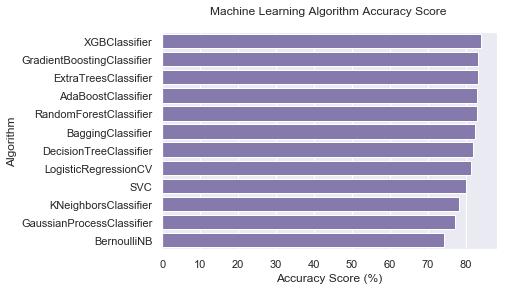

In [602]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

# Voting Classifier
***

<img src = '../images/Voting.gif'></img>

<b><i>The first step in a Voting Classifier is to train several Classifiers independently on the same data. Then aggregate the predictions of each classifier and predict the class that gets the most votes.</b></i>
<br>
<br>
In below step, we define the various classifiers/estimators we will be using to train the model.

In [605]:
estimators = [
    # Decision Tree
    ('dtree', tree.DecisionTreeClassifier(criterion = 'gini',max_depth = 4,random_state = 0)),
    
    #Ensemble Methods
    ('ada', AdaBoostClassifier(learning_rate = 0.1, n_estimators = 150, random_state = 0)),
    ('bc', BaggingClassifier(max_samples = 0.25, n_estimators = 30, random_state = 0)),
    ('etc',ExtraTreesClassifier(criterion = 'gini', max_depth = 6, n_estimators = 100, random_state = 0)),
    ('gbc', GradientBoostingClassifier(learning_rate = 0.05, max_depth = 5, n_estimators = 300, random_state = 0)),
    ('rfc', RandomForestClassifier(criterion = 'entropy', max_depth = 4, n_estimators = 30, oob_score = True, random_state = 0)),

    #Gaussian Processes
    ('gpc', GaussianProcessClassifier(max_iter_predict = 1, random_state = 0)),
    
    #GLM
    ('lr', LogisticRegressionCV(fit_intercept = True, random_state = 0, solver = 'lbfgs')),
    
    #Navies Bayes
    ('bnb', BernoulliNB(alpha = 0.6)),
    
    #Nearest Neighbor
    ('knn', KNeighborsClassifier(algorithm = 'auto', n_neighbors = 6, weights = 'distance')),
    
    #SVM
    ('svc', SVC(C = 5, decision_function_shape = 'ovo', gamma = 0.05, probability = True, random_state = 0)),
    
    #xgboost
   ('xgb', XGBClassifier(learning_rate = 0.25, max_depth = 4, n_estimators = 40, seed = 0))
]

<a id = 'hardVote'></a>
## Hard Voting Classifier
***
Scikit-Learn has a cool library called VotingClassifier that does the tast of training all the classifiers/estimators independently. We then used "cross_validate" to determine the efficiency of the Voting Classifier.

<img src = '../images/Hard_Voting.png'/>

In [606]:
#Hard Vote or majority rules
vote_hard = VotingClassifier(estimators = estimators , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X, y, scoring = 'accuracy', cv  = cv_split)
vote_hard.fit(X, y)

print("Hard Voting Training score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))

Hard Voting Training score mean: 89.36
Hard Voting Test score mean: 82.72


<a id = 'softVote'></a>
## Soft Voting Classifier
***
If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting.

In [607]:
#Soft Vote or majority rules
vote_soft = VotingClassifier(estimators = estimators , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X, y, scoring = 'accuracy', cv  = cv_split)
vote_soft.fit(X, y)

print("Soft Voting Training score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))

Soft Voting Training score mean: 92.37
Soft Voting Test score mean: 83.06


<a id = 'saveModels'></a>
## Save Models to file
***

In [620]:
import pickle

modelList = [(vote_hard, 'HardVotingClassifier.sav'),
            (vote_soft, 'SoftVotingClassifier.sav')]

for model, filename in modelList:
    pickle.dump(model, open("../models/"+filename, 'wb'))

# Submission
***

In [612]:
features.remove('Survived')

In [613]:
# Submission file 1 (Predictions using Hard Vote Classifier)
predictions = vote_hard.predict(test[features])
vote_hard_df = pd.DataFrame()
vote_hard_df['PassengerId'] = test_id
vote_hard_df['Survived'] = predictions

# first submission file
vote_hard_df.to_csv('../submissions/submission_vote_hard.csv',index=False)

In [615]:
# Submission file 2 (Predictions using Soft Vote Classifier)
predictions = vote_soft.predict(test[features])
vote_soft_df = pd.DataFrame()
vote_soft_df['PassengerId'] = test_id
vote_soft_df['Survived'] = predictions

# second submission file
vote_soft_df.to_csv('../submissions/submission_vote_soft.csv',index=False)

# Conclusion
***

In this notebook I successfully did analysis on which features have influences on the survival pattern of the passengers.I have also come up with few new features which are one of the deciding factors on "Survival" - <i>e.g.,"Title", "IsMotherBabyDuo", "IsAlone" and "Age*Class".
<br><br>
On submission of the prediction files by Hard Voting Classifier and Soft Voting Classifier, I got a score of 0.77022 in both the cases. However, the best score I got was using "BaggageClassifier" with "DecisionTree" set as its estimaotor. The score I reached was 0.78468.
<br><br>
While no general conclusions can be made from testing a handful of algorithms on a single dataset, but the observation I have made is that the train dataset has a different distribution than the test/validation dataset and population. This created wide margins between the cross validation (CV) accuracy score and Kaggle submission accuracy score.